In [1]:
import sys
import pandas as pd
import re
import scipy.stats as stats 
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

## Variables setting

In [2]:
datadir="../data/"
flagstatdir=datadir+"flagstat/"
countsdir=datadir+"counts/"
font_dir = "../fonts/"
imagesdir= "../images/"
U16_samples=('U16_2','U16_3','U16_4')
GFP_samples=('GFP_2','GFP_3','GFP_4')
St_samples=('St1', 'St3')

# Calculation of the FPKM from the FeatureCounts outputs
## 1. On the loci

In [3]:
nb_fragments={}
loci_fpkm_df=pd.DataFrame()
for s in U16_samples+GFP_samples+St_samples:
    flagstat=open(flagstatdir+s+".flagstat", 'r') 
    for l in flagstat:
        m=re.match("^(\d+) \+ 0 properly paired",l)
        if (m != None):
            nb_fragments[s]=int(m.group(1))
            ltmp=pd.read_csv(countsdir+s+".Hd2_provirus_loci_IVSPER2.counts.txt", comment="#", sep="\t", index_col="Geneid") 
            ltmp['locus ' + s]=1000000*(ltmp[s+'.bam']/nb_fragments[s])/(ltmp['Length']/1000)
            loci_fpkm_df=pd.concat([loci_fpkm_df, ltmp.loc[:,'locus '+s]], axis=1)
# Add the Chromosome name to the files
loci_fpkm_df=loci_fpkm_df.merge(ltmp.loc[:,'Chr'], left_index=True, right_index=True)

### Add the type of the loci ('evREP' or 'proviral segment') to the table 

In [4]:
provir=[]
evrep=[]
loci_fpkm_df.loc[:,'type']=''
for locus in loci_fpkm_df.index:
    if((re.match("^Hd", locus) != None) | (re.match("^similar to", locus) != None)):
        provir.append(locus)
        loci_fpkm_df.loc[locus,'type']='proviral segment'
    else:
        if(re.match("^IVSP", locus)!= None):
            evrep.append(locus)
            loci_fpkm_df.loc[locus,'type']='evREP'
        else:
            print("Error " + locus)
loci_fpkm_provir_df= loci_fpkm_df.loc[loci_fpkm_df['type']=='proviral segment',:]
loci_fpkm_evrep_df=loci_fpkm_df.loc[loci_fpkm_df['type']=='evREP',:]

In [5]:
## 2. On the random loci

In [6]:
random_provir_fpkm_df=pd.DataFrame()
random_evrep_fpkm_df=pd.DataFrame()
for s in U16_samples+GFP_samples+St_samples:
    retmp=pd.read_csv(countsdir+s+".evrep.randoms.counts.txt", comment="#", sep="\t", index_col="Geneid") 
    retmp['random ' + s]=1000000*(retmp["../"+s+'.bam']/nb_fragments[s])/(retmp['Length']/1000)
    random_evrep_fpkm_df=pd.concat([random_evrep_fpkm_df, retmp.loc[:,'random '+s]], axis=1)
    rptmp=pd.read_csv(countsdir+s+".provir.randoms.counts.txt", comment="#", sep="\t", index_col="Geneid") 
    rptmp['random ' + s]=1000000*(rptmp["../"+s+'.bam']/nb_fragments[s])/(rptmp['Length']/1000)
    random_provir_fpkm_df=pd.concat([random_provir_fpkm_df, rptmp.loc[:,'random '+s]], axis=1)
# Add the Chromosome name to the files
random_evrep_fpkm_df=random_evrep_fpkm_df.merge(retmp.loc[:,('Chr', 'Start', 'End')], left_index=True, right_index=True)
random_provir_fpkm_df=random_provir_fpkm_df.merge(rptmp.loc[:,('Chr', 'Start', 'End')], left_index=True, right_index=True)

# statistical tests St3 vs St1

In [7]:
st3st1_evrep_melted=loci_fpkm_evrep_df.reset_index().melt(id_vars=['index'], value_vars=( 'locus St1' ,'locus St3'))
st3st1_evrep_melted['sample']=st3st1_evrep_melted['variable'].str.replace("locus ",'').str.split("_").str[0]
st3st1_provir_melted=loci_fpkm_provir_df.reset_index().melt(id_vars=['index'], value_vars=( 'locus St1' ,'locus St3'))
st3st1_provir_melted['sample']=st3st1_provir_melted['variable'].str.replace("locus ",'').str.split("_").str[0]
st3st1_provir_random_melted=random_provir_fpkm_df.reset_index().melt(id_vars=['index'], value_vars=('random St1' ,'random St3' ))
st3st1_provir_random_melted['sample']=st3st1_provir_random_melted['variable'].str.replace("random ",'').str.split("_").str[0]
st3st1_evrep_random_melted=random_evrep_fpkm_df.reset_index().melt(id_vars=['index'], value_vars=('random St1' ,'random St3' ))
st3st1_evrep_random_melted['sample']=st3st1_evrep_random_melted['variable'].str.replace("random ",'').str.split("_").str[0]

### St1 proviral segments vs random loci

In [8]:
all_provir_melted=pd.concat([st3st1_provir_melted, st3st1_provir_random_melted])
stats.ttest_ind(all_provir_melted.loc[all_provir_melted['variable']=='locus St1', 'value'],all_provir_melted.loc[all_provir_melted['variable']=='random St1', 'value'], equal_var=False)

TtestResult(statistic=-0.8270331715897284, pvalue=0.40989819222458734, df=117.25204218709717)

### St1 evREP vs random loci

In [9]:
all_evrep_melted=pd.concat([st3st1_evrep_melted, st3st1_evrep_random_melted])
stats.ttest_ind(all_evrep_melted.loc[all_evrep_melted['variable']=='locus St1', 'value'],all_evrep_melted.loc[all_evrep_melted['variable']=='random St1', 'value'], equal_var=False)

TtestResult(statistic=-0.2420543847796417, pvalue=0.8118530263373945, df=15.793533043159067)

### St3 proviral segments vs random loci

In [10]:
stats.ttest_ind(all_provir_melted.loc[all_provir_melted['variable']=='locus St3', 'value'],all_provir_melted.loc[all_provir_melted['variable']=='random St3', 'value'], equal_var=False)

TtestResult(statistic=7.871206470681912, pvalue=1.414463804990572e-10, df=55.00002465652294)

### St3 evREP vs random loci

In [11]:
stats.ttest_ind(all_evrep_melted.loc[all_evrep_melted['variable']=='locus St3', 'value'],all_evrep_melted.loc[all_evrep_melted['variable']=='random St3', 'value'], equal_var=False)

TtestResult(statistic=3.1162839902973585, pvalue=0.010942941542914404, df=10.000027598316569)

# Figures

In [12]:
# Add every font at the specified location
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
mpl.rcParams['font.family'] = 'Arial'

## Figure 2 (boxplots St1/St3)

In [13]:
colors_sample = ["#f20e1c", "#fcaf22","#31ee13","#fcaf22"]

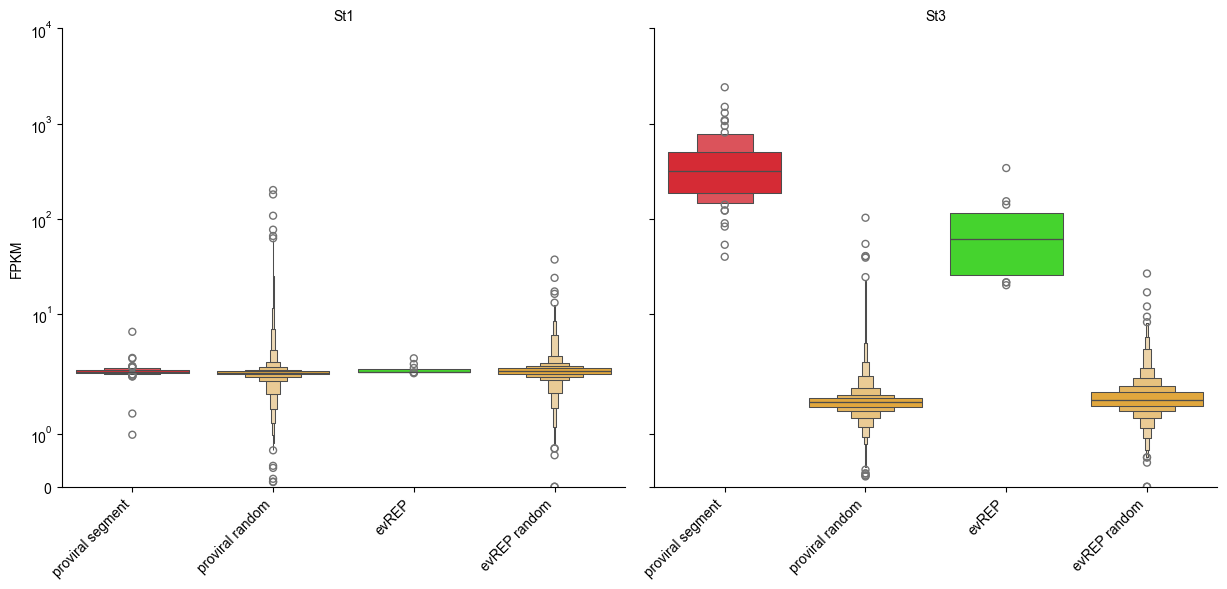

In [14]:
st3st1_provir_random_melted['type']='proviral random'
st3st1_provir_random_melted['target']='proviral loci'
st3st1_evrep_random_melted['type']='evREP random'
st3st1_evrep_random_melted['target']='evREP'
st3st1_provir_melted['type']='proviral segment'
st3st1_evrep_melted['type']='evREP'
st3st1_provir_melted['target']='proviral loci'
st3st1_evrep_melted['target']='evREP'

myPalette= sns.set_palette(sns.color_palette(colors_sample))
all_melted=pd.concat([st3st1_provir_melted, st3st1_provir_random_melted, st3st1_evrep_melted,st3st1_evrep_random_melted])
#g=sns.catplot(
#    data=all_melted, x="type", y="value", col="sample", hue="type",  kind='violin', gap=.01, inner="quart", split=True, height=6, aspect=1.0
#)

g=sns.catplot(
    data=all_melted, x="type", y="value", col="sample", hue="type",  kind='boxen',  height=6, aspect=1.0
)


for i in range(g.axes.size): 
    subplot=g.axes[0,i]
    subplot.set_yscale("symlog")
    subplot.set_xticks(subplot.get_xticks())
    subplot.set_xticklabels(
    subplot.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right'    
    )
    subplot.set_ylabel('FPKM')
    subplot.set_xlabel('')
    subplot.set(ylim=(0,10000))

g.legend.remove()
g.set_titles("{col_name}")
plt.tight_layout() 
plt.savefig(imagesdir+"figure2.png")

## figure 3a (U16/GFP, proviral segments) 

In [15]:
color_U16="#ff5e4d"
color_GFP="#80d0d0"
color_rand="#fcaf22"
colors=[color_U16, color_GFP, color_rand, color_rand]
allPalette = sns.set_palette(sns.color_palette(colors))

In [16]:
provir_melted=loci_fpkm_provir_df.reset_index().melt(id_vars=['index'], value_vars=( 'locus U16_2' ,'locus U16_3' , 'locus U16_4' , 'locus GFP_2' ,'locus GFP_3','locus GFP_4'))
provir_melted['sample']=provir_melted['variable'].str.replace("locus ",'').str.split("_").str[0]
random_provir_melted=random_provir_fpkm_df.reset_index().melt(id_vars=['index'], value_vars=('random U16_2' ,'random U16_3' , 'random U16_4' , 'random GFP_2' ,'random GFP_3','random GFP_4'))
random_provir_melted['sample']='random ' + random_provir_melted['variable'].str.replace("random ",'').str.split("_").str[0]

In [17]:
pd.concat([provir_melted, random_provir_melted])

,index,variable,value,sample
0,Hd26,locus U16_2,29.865484,U16
1,Hd38,locus U16_2,33.934862,U16
2,Hd36,locus U16_2,16.427440,U16
3,Hd50,locus U16_2,6.146538,U16
4,Hd49,locus U16_2,18.533200,U16
...,...,...,...,...
33595,random5596,random GFP_4,2.140258,random GFP
33596,random5597,random GFP_4,1.757121,random GFP
33597,random5598,random GFP_4,1.792275,random GFP
33598,random5599,random GFP_4,2.064424,random GFP


In [18]:
pd.concat([provir_melted, random_provir_melted])['sample'].unique()

array(['U16', 'GFP', 'random U16', 'random GFP'], dtype=object)

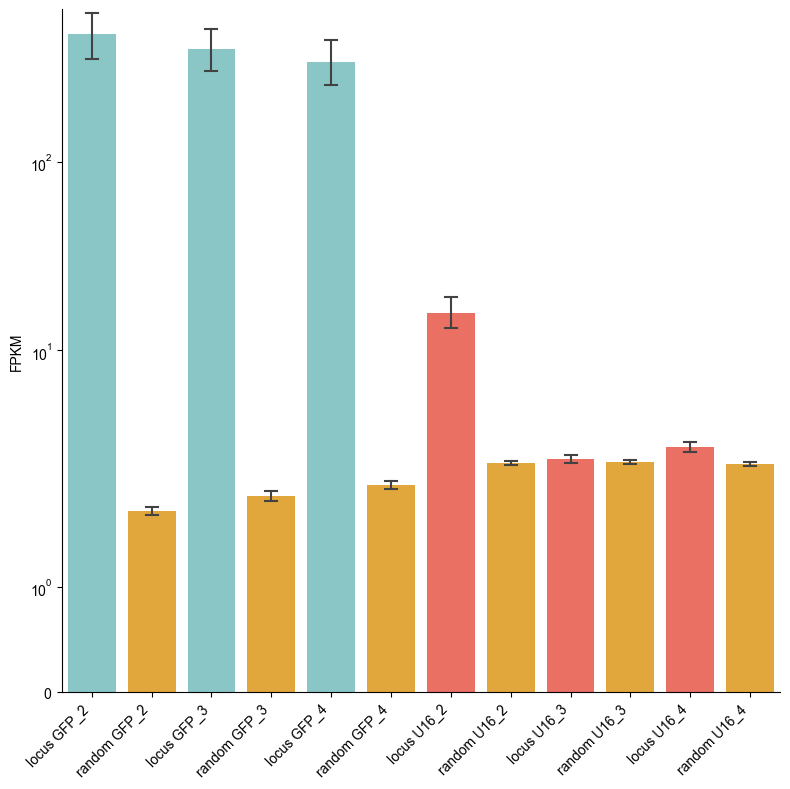

In [19]:
g=sns.catplot(
    data=pd.concat([provir_melted, random_provir_melted]), x="variable", y="value", kind='bar', palette=allPalette,
    order=('locus GFP_2','random GFP_2','locus GFP_3','random GFP_3','locus GFP_4','random GFP_4','locus U16_2','random U16_2','locus U16_3','random U16_3','locus U16_4','random U16_4'),
    height=8, aspect=1.0,
    edgecolor='black',
    hue='sample',
    err_kws={'linewidth': 1.5},
    capsize=0.2,
    legend=False
)

for i in range(g.axes.size): 
    subplot=g.axes[0,i]
    subplot.set_yscale("symlog")
    subplot.set_xticks(subplot.get_xticks())
    subplot.set_xticklabels(
    subplot.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right'    
    )
    subplot.set_ylabel('FPKM')
    subplot.set_xlabel('')
g.set_titles("{col_name}")
plt.tight_layout() 
plt.savefig(imagesdir+"figure3a.png")

### statistical test U16 vs GFP

In [20]:
stats.ttest_ind(provir_melted.loc[provir_melted['sample']=='U16', 'value'],provir_melted.loc[provir_melted['sample']=='GFP', 'value'], equal_var=False)

TtestResult(statistic=-12.420737106665213, pvalue=1.6322158648860663e-25, df=167.16509554151446)

### statistical test GFP vs GFP random

In [21]:
stats.ttest_ind(provir_melted.loc[provir_melted['sample']=='GFP', 'value'],random_provir_melted.loc[random_provir_melted['sample']=='random GFP', 'value'], equal_var=False)

TtestResult(statistic=12.59270869680673, pvalue=5.417355675841799e-26, df=167.000055636639)

### statistical test U16 vs U16 random

In [22]:
stats.ttest_ind(provir_melted.loc[provir_melted['sample']=='U16', 'value'],random_provir_melted.loc[random_provir_melted['sample']=='random U16', 'value'], equal_var=False)

TtestResult(statistic=6.637867304942053, pvalue=4.250774639779173e-10, df=167.1898690050097)

## figure 3b (U16/GFP, evREP)

In [23]:
evrep_melted=loci_fpkm_evrep_df.reset_index().melt(id_vars=['index'], value_vars=('locus U16_2' ,'locus U16_3' , 'locus U16_4' , 'locus GFP_2' ,'locus GFP_3','locus GFP_4'))
evrep_melted['sample']=evrep_melted['variable'].str.replace("locus ",'').str.split("_").str[0]
random_evrep_melted=random_evrep_fpkm_df.reset_index().melt(id_vars=['index'], value_vars=('random U16_2' ,'random U16_3' , 'random U16_4' , 'random GFP_2' ,'random GFP_3','random GFP_4'))
random_evrep_melted['sample']='random ' + random_evrep_melted['variable'].str.replace("random ",'').str.split("_").str[0]

In [24]:
all_melted=pd.concat([evrep_melted, random_evrep_melted])
all_melted

,index,variable,value,sample
0,IVSP_U37,locus U16_2,7.427280,U16
1,IVSP_U42*,locus U16_2,4.122450,U16
2,IVSP_U38*,locus U16_2,4.105013,U16
3,IVSPER-5,locus U16_2,3.951289,U16
4,IVSPER-3,locus U16_2,17.937047,U16
...,...,...,...,...
6595,random1096,random GFP_4,1.148101,random GFP
6596,random1097,random GFP_4,2.292108,random GFP
6597,random1098,random GFP_4,1.951602,random GFP
6598,random1099,random GFP_4,1.742170,random GFP


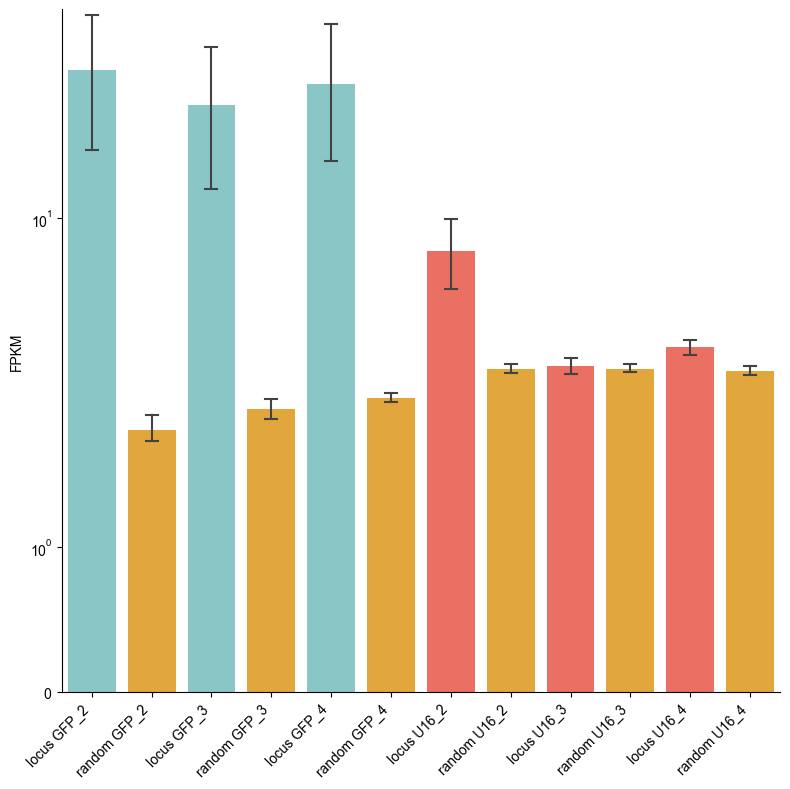

In [25]:
g=sns.catplot(
    data=pd.concat([evrep_melted, random_evrep_melted]), x="variable", y="value", kind='bar',
    height=8, aspect=1.0,
    order=('locus GFP_2','random GFP_2','locus GFP_3','random GFP_3','locus GFP_4','random GFP_4','locus U16_2','random U16_2','locus U16_3','random U16_3','locus U16_4','random U16_4'),
    edgecolor='black',
    hue='sample',
    err_kws={'linewidth': 1.5},
    capsize=0.2,
    legend=False
)

for i in range(g.axes.size): 
    subplot=g.axes[0,i]
    subplot.set_yscale("symlog")
    subplot.set_xticks(subplot.get_xticks())
    subplot.set_xticklabels(
    subplot.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right'    
    )
    subplot.set_ylabel('FPKM')
    subplot.set_xlabel('')

g.set_titles("{col_name}")
plt.tight_layout() 
#plt.suptitle("St3/St1 loci FPKM", y=1.1)
plt.savefig(imagesdir+"figure3b.png")

### statistical test U16 vs GFP

In [26]:
stats.ttest_ind(evrep_melted.loc[evrep_melted['sample']=='U16', 'value'],evrep_melted.loc[evrep_melted['sample']=='GFP', 'value'], equal_var=False)

TtestResult(statistic=-4.908368713589503, pvalue=2.4747885561911476e-05, df=32.654584983772104)

### statistical test GFP vs GFP random

In [27]:
stats.ttest_ind(evrep_melted.loc[evrep_melted['sample']=='GFP', 'value'],random_evrep_melted.loc[random_evrep_melted['sample']=='random GFP', 'value'], equal_var=False)

TtestResult(statistic=5.3854572222852415, pvalue=6.471257605818763e-06, df=32.001197677733266)

### statistical test U16 vs U16 random

In [28]:
stats.ttest_ind(evrep_melted.loc[evrep_melted['sample']=='U16', 'value'],random_evrep_melted.loc[random_evrep_melted['sample']=='random U16', 'value'], equal_var=False)

TtestResult(statistic=3.2232509330704717, pvalue=0.002901926689299842, df=32.18109019396961)

## figure 3c (mean FPKM by scaffolds, evREP)

In [29]:
evrep_melted=evrep_melted.merge(loci_fpkm_df['Chr'], left_on='index', right_index=True)

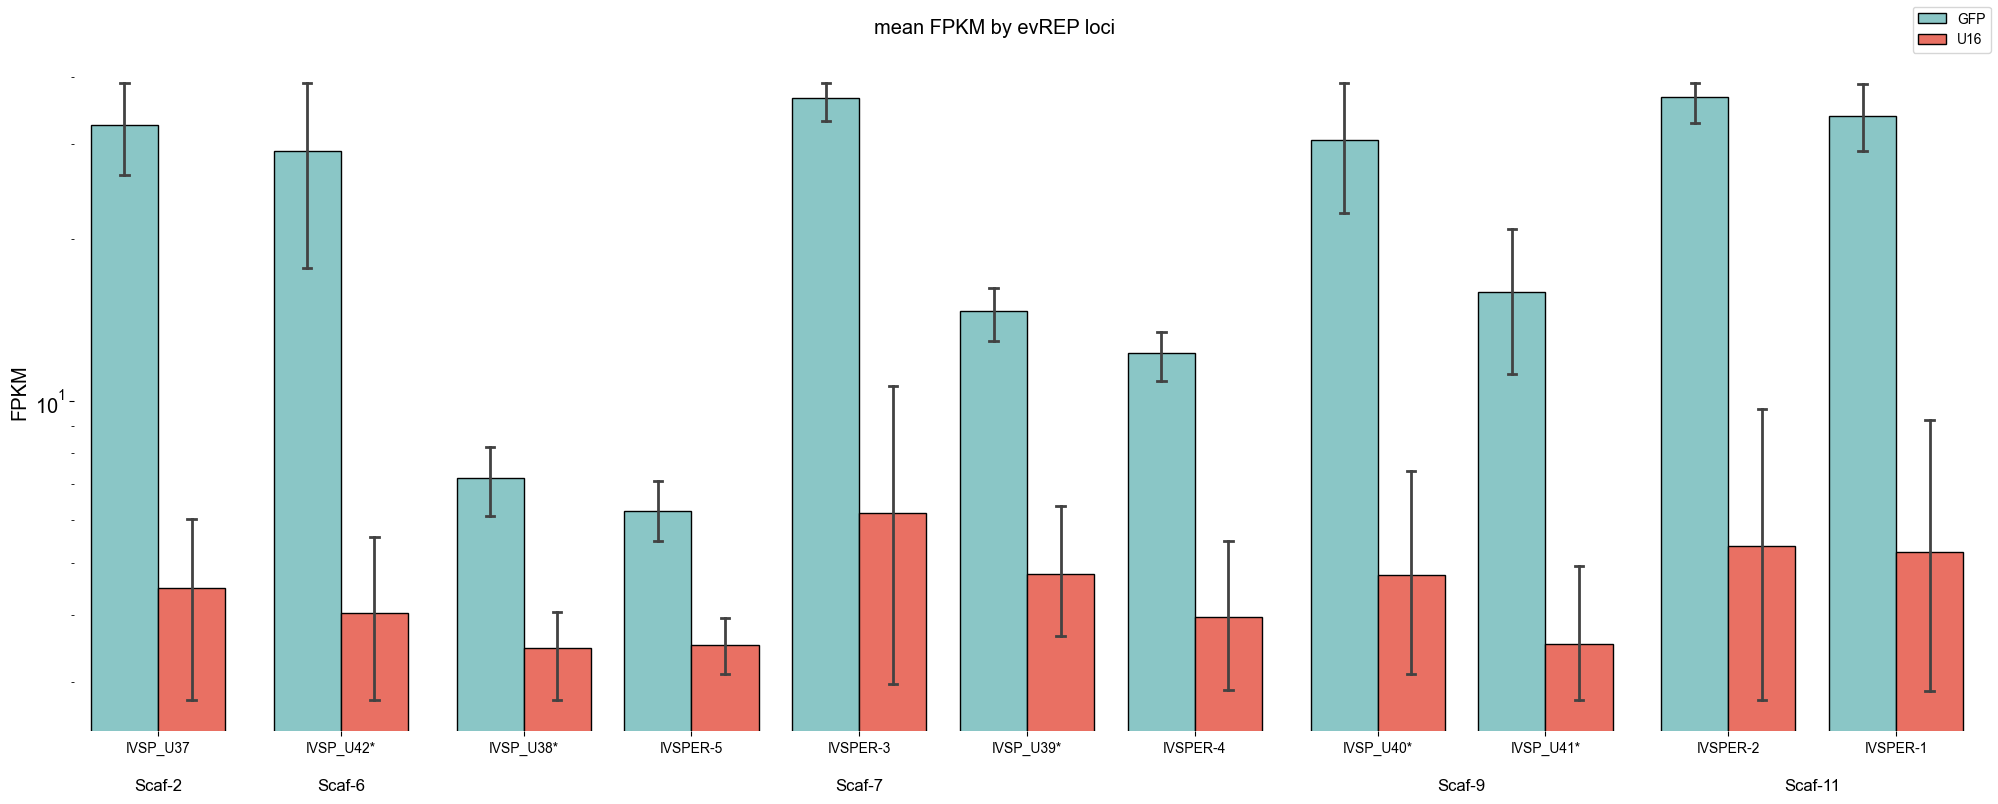

In [30]:
colors_sample=[color_GFP, color_U16]
allPalette = sns.set_palette(sns.color_palette(colors_sample))
mpl.rcParams['ytick.labelsize'] = 'x-large'
fig, axes = plt.subplots(1, 5, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1, 5, 2,2]})
plt.subplots_adjust(wspace=0.2)
fig.suptitle('mean FPKM by evREP loci', size='x-large')

sns.barplot(ax=axes[0],data=evrep_melted.loc[evrep_melted['Chr']=='HD2_scaffold_2'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,capsize=0.1,  err_kws={'linewidth': 2.0})
sns.barplot(ax=axes[1],data=evrep_melted.loc[evrep_melted['Chr']=='HD2_scaffold_6'], x="index", y="value", hue="sample",hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,capsize=0.1, err_kws={'linewidth': 2.0})
sns.barplot(ax=axes[2],data=evrep_melted.loc[evrep_melted['Chr']=='HD2_scaffold_7'], x="index", y="value", hue="sample",hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,capsize=0.1, err_kws={'linewidth': 2.0})
sns.barplot(ax=axes[3],data=evrep_melted.loc[evrep_melted['Chr']=='HD2_scaffold_9'], x="index", y="value", hue="sample",hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,capsize=0.1, err_kws={'linewidth': 2.0})
sns.barplot(ax=axes[4],data=evrep_melted.loc[evrep_melted['Chr']=='HD2_scaffold_11'], x="index", y="value", hue="sample",hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,capsize=0.1, err_kws={'linewidth': 2.0})
chrs={0:2,1:6,2:7,3:9,4:11}
for i in range(5):
    axes[i].set_title('Scaf-'+str(chrs[i]),  y=-0.1)
    axes[i].set_yscale('log')
    axes[i].get_legend().remove()
    plt.setp(axes[i].get_xticklabels(), horizontalalignment='center')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('FPKM', fontsize='x-large')
    if (i != 0):
        axes[i].get_yaxis().set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

for ax in axes.flat:
    ax.label_outer()

plt.tight_layout() 
plt.savefig(imagesdir+"figure3c.png")

## figure 3c (mean FPKM by scaffolds, evREP)

In [31]:
provir_melted=provir_melted.merge(loci_fpkm_df['Chr'], left_on='index', right_index=True)
provir_melted.loc[provir_melted['index']=='similar to Hd2', 'index']='Hd2l'

In [32]:
provir_melted

,index,variable,value,sample,Chr
0,Hd26,locus U16_2,29.865484,U16,HD2_scaffold_1
56,Hd26,locus U16_3,2.568894,U16,HD2_scaffold_1
112,Hd26,locus U16_4,2.884571,U16,HD2_scaffold_1
168,Hd26,locus GFP_2,960.896299,GFP,HD2_scaffold_1
224,Hd26,locus GFP_3,772.508449,GFP,HD2_scaffold_1
...,...,...,...,...,...
111,Hd35,locus U16_3,3.751278,U16,HD2_scaffold_12
167,Hd35,locus U16_4,4.964164,U16,HD2_scaffold_12
223,Hd35,locus GFP_2,1174.573466,GFP,HD2_scaffold_12
279,Hd35,locus GFP_3,923.296160,GFP,HD2_scaffold_12


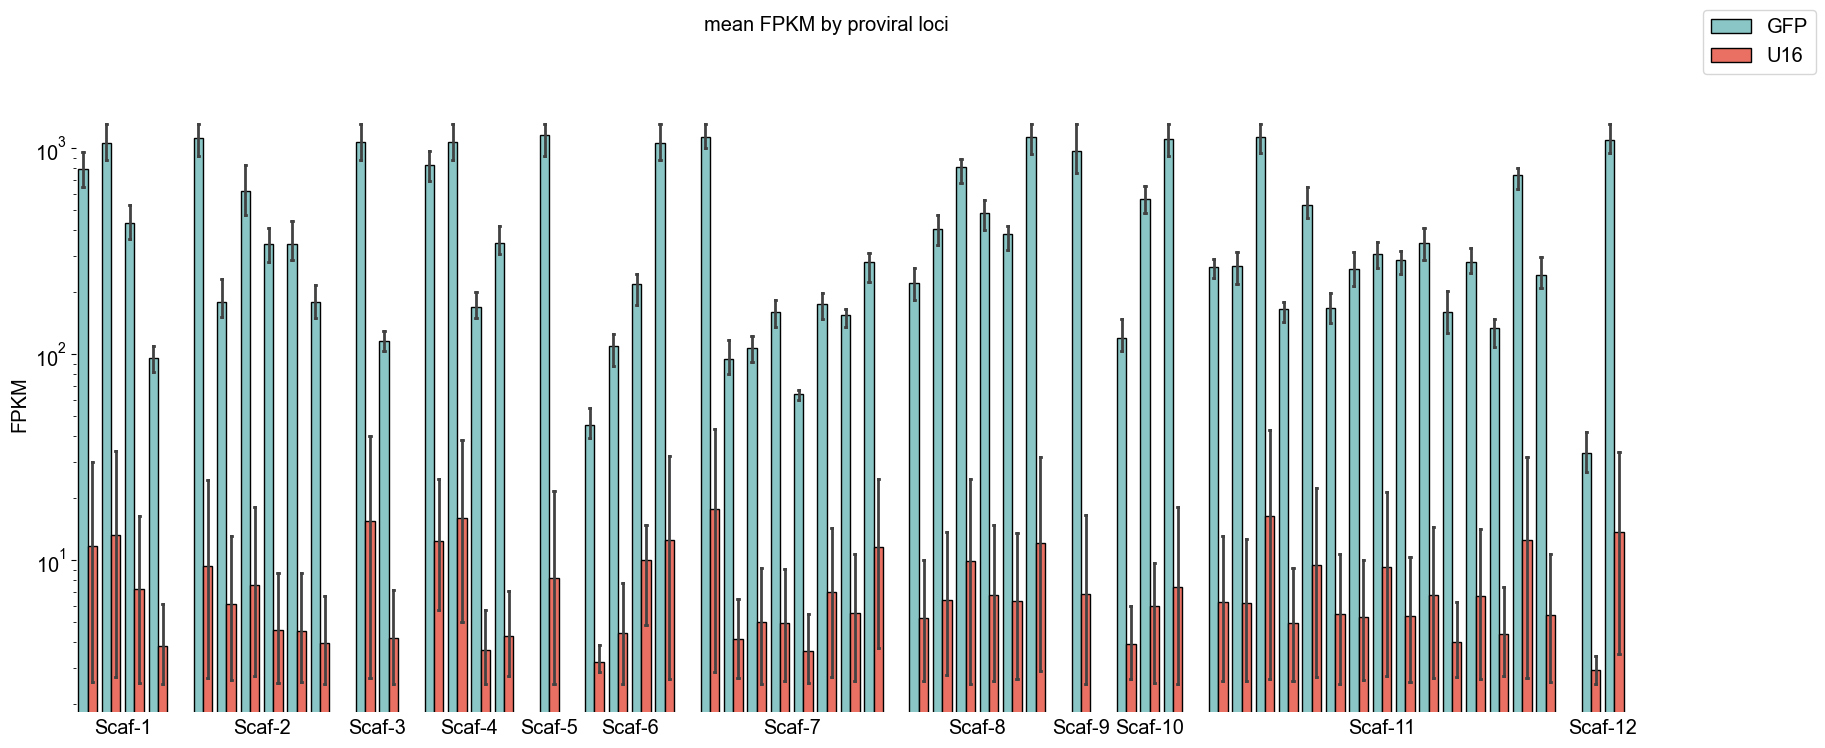

In [34]:
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large'
mpl.rcParams['axes.titlesize'] = 'x-large'
fig, axes = plt.subplots(1, 12, figsize=(20, 8), gridspec_kw={'width_ratios': [6, 9, 3, 6,1.5, 6,12,9,1.5, 4.5,22.5, 3]})
plt.subplots_adjust(wspace=0.2)
fig.suptitle('mean FPKM by proviral loci', size='x-large')

sns.barplot(ax=axes[0],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_1'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8, err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[1],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_2'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8, err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[2],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_3'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8, err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[3],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_4'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[4],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_5'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[5],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_6'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[6],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_7'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[7],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_8'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[8],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_9'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[9],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_10'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[10],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_11'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
sns.barplot(ax=axes[11],data=provir_melted.loc[provir_melted['Chr']=='HD2_scaffold_12'], x="index", y="value", hue="sample", hue_order=('GFP', 'U16'), edgecolor='black', width=0.8,  err_kws={'linewidth': 2.0},capsize=0.1)
for i in range(12):
    axes[i].set_title('Scaf-'+str(i+1),  y=-0.05)
    axes[i].set_yscale('log')
    axes[i].get_legend().remove()
    axes[i].set_xticks([])
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    if (i != 0):
        axes[i].get_yaxis().set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('FPKM', fontsize='x-large')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize='x-large')
#plt.tight_layout() 
plt.savefig(imagesdir+"figure3d.png")